In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import csv
# import umap
import scanpy as sc

def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

In [2]:
import h5py
from scipy.sparse import csr_matrix

def load_data(dataset,gene_percent_cells=0.01,peak_percent_cells=0.001,include_h5=True,
              preprocess=True,sampling=None,distance=1000000):
    
    data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

    if sampling == 'geosketch':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.sketch.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.sketch.h5ad'.format(dataset)))
    elif sampling == 'uniform':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.uniform.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.uniform.h5ad'.format(dataset)))        
    else:
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.h5ad'.format(dataset)))

    if dataset == 'sci_car':
        data_dir = '/data/cb/alexwu/mm_finemap/data/sci_car'
        adata = sc.read(os.path.join(data_dir,'adata-hs.h5ad'))

        atac_adata.var['chr_no'] = ['chr' + n for n in atac_adata.var['chr_no']]
        atac_adata.var['start'] = adata.uns['atac.var'][:,2].astype(int)
        atac_adata.var['end'] = adata.uns['atac.var'][:,3].astype(int)

    if preprocess:
        # scale by maximum 
        # (rna already normalized by library size + log-transformed)
        X_max = rna_adata.X.max(0).toarray().squeeze()
        X_max[X_max == 0] = 1
        rna_adata.X = csr_matrix(rna_adata.X / X_max)

        # atac: normalize library size + log transformation
        sc.pp.normalize_total(atac_adata,target_sum=1e4)
        sc.pp.log1p(atac_adata)

    if include_h5:
        data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
        with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
            print(f.keys())
            data_df = pd.DataFrame()
            for k in ['chr_no','eqtl','hic','dist','atac_id','gene','corr','group_corr','gene_percent_cells',
                      'peak_percent_cells','hg38tohg19_eqtl','eqtl.new','corr_bin','group_corr_bin',
                      'hic_0hr','hic_1hr','hic_4hr','eqtl.q','hic_4hr.expectedBL','eqtl.all','hic.new2',
                      'hic.100kb','ABC.score'] + ['placseq_{}'.format(c) for c in ['eN','iN','IPC','RG']]: #,
#                      'hic_0hr.expectedBL','hic_1hr.expectedBL','hic_4hr.expectedBL.new','hic_0hr.expectedBL.new',
#                      'hic_4hr.expectedBL.new2','hic_12hr.expectedBL','hic_4hr.expectedBL.full']:
                if k in f.keys():
                    data_df[k] = f[k][:]

        small_df = data_df[abs(data_df['dist']) < distance]

        # small_df = small_df[~np.isnan(small_df['group_corr'])]
        small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
        small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

        small_df.index = [(atac_idx,gene) for atac_idx,gene in small_df[['atac_id','gene']].values]
    
        return rna_adata,atac_adata,small_df

    else:
        
        return rna_adata,atac_adata

In [3]:
['placseq_{}'.format(c) for c in ['eN','iN','IPC','RG']]

'''
eN: excitatory neurons
iN: interneurons
IPC: intermediate progenitor cells
RG: radial glia
'''

'\neN: excitatory neurons\niN: interneurons\nIPC: intermediate progenitor cells\nRG: radial glia\n'

In [4]:
from scipy.stats import rankdata

def load_results(dataset,eval_df,ensemble=False,gene_percent_cells=0.01,peak_percent_cells=0.001):
    
    n_layers = 10
    n_neighbors = 15
    mode = 'lr'

    eval_df['ABC.score'] = eval_df['ABC.score'].replace(np.nan, 0)
    eval_df['ABC.score'] = eval_df['ABC.score'].values #.astype(bool).astype(float)

    eval_df['corr'] = eval_df['corr'].replace(np.nan, 0)
    eval_df['group_corr'] = eval_df['group_corr'].replace(np.nan, 0)

    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)

    
    if dataset in ['sci_car','snare_seq']:
        
        method = 'graph'
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
        for trial_no in range(1,6):

            file_name = 'graph.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
            scores[np.isinf(scores)] = 10**10
            eval_df['{}.trial{}'.format(method,trial_no)] = scores
            
    elif dataset in ['share_seq_more','human_cortex_multiome_lineage']:
        
        method = 'graph'
        for trial_no in range(1,6):

            if trial_no == 1:
                data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
            else:
                data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

            if dataset == 'human_cortex_multiome_lineage':
                file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            elif dataset == 'share_seq_more':
                file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            else:
                file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

            scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
            scores[np.isinf(scores)] = 10**10
            eval_df['{}.trial{}'.format(method,trial_no)] = scores
            
        
            if trial_no == 1:
                data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
            else:
                data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}_{}'.format(dataset,trial_no)

            # correlations
            with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
                data_df = pd.DataFrame()
                for k in ['dist','corr','group_corr','gene_percent_cells','peak_percent_cells']:
                    if k in f.keys():
                        data_df[k] = f[k][:]

            small_df = data_df[abs(data_df['dist']) < distance]

            # small_df = small_df[~np.isnan(small_df['group_corr'])]
            small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
            small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

            eval_df['corr.trial{}'.format(trial_no)] = small_df['corr'].replace(np.nan, 0).values
            eval_df['group_corr.trial{}'.format(trial_no)] = small_df['group_corr'].replace(np.nan, 0).values

    if ensemble:
                
        for method in ['graph','corr','group_corr']:
            eval_df['{}.ranks.mean'.format(method)] = np.array([rankdata(abs(eval_df['{}.trial{}'.format(method,trial_no)].values),
                                                                method='average') for trial_no in range(1,6)]).mean(0)

#         distance_ranks = rankdata(-abs(eval_df['dist'].values),method='average')
#         eval_df['dist_ranks'] = distance_ranks

#         for feature in ['graph.ranks.mean','group_corr.ranks.mean','corr.ranks.mean']:
#             eval_df[feature + '-dist'] = (distance_ranks + eval_df[feature].values)/2
            
    return eval_df

In [5]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def get_results(dataset,method,n_layers=None,n_neighbors=None,mode=None,sketch=False,trial_no=None,new=True):
    
    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
    
    if method == 'graph':
        trial_str = 'new2' if trial_no == 0 else 'trial{}'.format(trial_no)
        if sketch:
            file_name = 'graph.sketch.{}.all.max_scale.mseloss.{}layers.nn{}.{}.p.txt'.format(trial_str,n_layers,n_neighbors,mode)
        else:
            file_name = 'graph.{}.all.max_scale.mseloss.{}layers.nn{}.{}.p.txt'.format(trial_str,n_layers,n_neighbors,mode)
    elif method == 'granger':
        if sketch:
            file_name = 'baseline.bin.sketch.bin.results.txt'
        else:
            file_name = 'baseline.bin.bin.results.txt'
    elif method == 'graph.base':
        if sketch:
            file_name = 'graph.base.sketch.new.{}layers.nn{}.{}.txt'.format(n_layers,n_neighbors,mode)
        else:
            file_name = 'graph.base.new.{}layers.nn{}.{}.txt'.format(n_layers,n_neighbors,mode)
            
    elif method == 'gvar':
        if sketch:
            file_name = 'gvar.bin.sketch.trial{}.results.txt'.format(trial_no)
        else:
            file_name = 'gvar.bin.trial{}.bin.results.txt'.format(trial_no)

    elif method == 'GVAR':
        if sketch:
            file_name = 'GVAR.bin.sketch.trial{}.bin.results.txt'.format(trial_no)
        else:
            file_name = 'GVAR.bin.trial{}.bin.results.txt'.format(trial_no)
            
    scores = pd.read_csv(os.path.join(data_dir,file_name),header=None).values
    if scores.shape[1] > 1:
        scores = scores[:,2]
    
    if (method == 'graph' and mode == 'lr') or method == 'gvar':
        return scores
    else:
        scores[scores == 0] = 10**-100
        scores = -np.log10(scores)
        return scores

def print_results(eval_df,method_list,feature,thresh,direction,metric='auprc'):
    
    if direction == 'less':
        y_true = eval_df[feature].values <= thresh
    elif direction == 'greater':
        y_true = eval_df[feature].values >= thresh

#     print('\nBASELINE:',y_true.mean(),'----------\n')

    data_dict = {'method': [], metric: []}
    for method in method_list:
        scores = abs(eval_df[method].values)
#         if 'corr' in method:
#             scores = abs(scores)
#         elif 'dist' in method:
#             scores = -abs(scores)
                
        if metric == 'auprc':
            value = average_precision_score(y_true,scores)
        elif metric == 'auroc':
            value = roc_auc_score(y_true,scores)
#         elif metric == 'f1':
#             scores = (scores > np.percentile(scores,99)).astype(int)
#             value = f1_score(y_true,scores)
            
        auprc = average_precision_score(y_true,scores)
        data_dict['method'].append(method)
        data_dict[metric].append(value)

    results_df = pd.DataFrame(data_dict)
    results_df['trial_no'] = [int(n.split('trial')[1]) if 'trial' in n else 0 for n in results_df['method']]
    results_df['method'] = [n.split('.trial')[0] for n in results_df['method']]
    
    return results_df

def get_precision_recall(eval_df,method,feature,percentile,direction):
    
    scores_list = []
    y_true_list = []
    for chr_no in sorted(list(set(eval_df['chr_no'].values))):
        
        chr_df = eval_df[eval_df['chr_no'] == chr_no]

        thresh = np.percentile(chr_df[feature].values,percentile)
        
        if direction == 'less':
            y_true = abs(chr_df[feature].values) <= thresh
        elif direction == 'greater':
            y_true = abs(chr_df[feature].values) >= thresh
            
        y_true_list.extend(y_true.astype(int).tolist())
        scores_list.extend(chr_df[method].values.tolist())
    
    y_true = np.array(y_true_list)
    
    scores = np.array(scores_list)
    if 'corr' in method:
        scores = abs(scores)
    elif 'dist' in method:
        scores = -abs(scores)

    precision, recall, thresholds = precision_recall_curve(y_true,scores)
    return precision, recall, thresholds

In [6]:
import math

def round_sigfigs(number,significant_digits=3):
    return round(number, significant_digits - int(math.floor(math.log10(abs(number)))) - 1)

def num_sigfigs(number):
    return len(str(number).split('.')[1].strip('0'))
    
def create_plot(results_df,metric):
    
    plt.figure(figsize=(len(set(results_df['method']))/2,5))
    sns.barplot(x='method',y=metric,hue='method',data=results_df,capsize=0.1,dodge=False)
    plt.ylim(0,results_df[metric].max()*1.02)
    plt.xlabel('',fontsize=16)
    plt.ylabel(metric.upper(),fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=90)
    

In [7]:
from scipy.stats import f
from statsmodels.stats.multitest import fdrcorrection

def lr_ftest(lr,n_layers,n):
    
    # number of reduced model parameters (W,b for each RNA layer)
    p1 = n_layers * 2 
    # number of full model parameters (W,b for each layer of RNA, ATAC + interaction)
    p2 = n_layers * 2 * 2 + 1 
    
    dfn = 2 * n_layers + 1
    dfd = n - 4 * n_layers - 1

    F = (lr - 1) * (n - p2)/(p2-p1)

    return 1-f.cdf(F,dfn,dfd)

def calculate_fdr(p):
    
    return fdrcorrection(p)[1]

In [8]:
def calculate_correlations(data_df,rna_adata,atac_adata,corr_key):
    
    if 'atac_idx' in data_df.keys() and 'atac_id' not in data_df.keys():
        data_df['atac_id'] = data_df['atac_idx'].values
        
    corr_dict = {}
    for chr_no in sorted(list(set(data_df['chr_no'].values))):
        print(chr_no)
        filtered_data_df = data_df[data_df['chr_no'] == chr_no]

        gene_inds = sorted(list(set(filtered_data_df['gene'].values)))
        atac_inds = list(map(str,sorted(list(set(filtered_data_df['atac_id'].values)))))

        filtered_rna_X = rna_adata[:,gene_inds].X.toarray()
        filtered_atac_X = atac_adata[:,atac_inds].X.toarray()

        rho = corr2_coeff(filtered_rna_X.T,filtered_atac_X.T)
        df = pd.DataFrame(rho,index=gene_inds,columns=atac_inds)
        print(df)

        for gene,atac_idx in filtered_data_df[['gene','atac_id']].values:
            corr_dict[(gene,atac_idx)] = df.loc[gene,str(atac_idx)]
            
    corr_list = []
    for gene,atac_idx in data_df[['gene','atac_id']].values:
        corr_list.append(corr_dict[(gene,atac_idx)])

    data_df[corr_key] = corr_list

    return data_df

def create_metacells(rna_adata,atac_adata):
    
    group_rna_X = []
    group_atac_X = []
    rna_X = rna_adata.X.toarray()
    rna_X = (((np.exp(rna_X)-1)/1e5).T*rna_adata.obs['n_counts'].values).T # raw counts

    for i in range(rna_adata.shape[0]):
        inds = np.nonzero(rna_adata.obsp['distances'][i])[1]
        inds = np.array(list(inds) + [i])
        group_rna_X.append(rna_X[inds].sum(0))
        group_atac_X.append(atac_adata[inds].X.sum(0))

        if i % 1000 == 0:
            print(i)

    group_rna_X = np.array(group_rna_X).squeeze()
    group_atac_X = np.array(group_atac_X).squeeze()
    
    group_rna_adata = rna_adata.copy()
    group_atac_adata = atac_adata.copy()

    group_rna_adata.X = group_rna_X #.copy()
    group_atac_adata.X = group_atac_X #.copy()
    
    sc.pp.normalize_total(group_rna_adata,target_sum=1e5)
    sc.pp.log1p(group_rna_adata)

    sc.pp.normalize_total(group_atac_adata,target_sum=1e4)
    sc.pp.log1p(group_atac_adata)
    
    return group_rna_adata,group_atac_adata

def perform_correlation_calculations(data_df,rna_adata,atac_adata,dataset,mode):
    
    rna_adata_copy = rna_adata.copy()
    atac_adata_copy = atac_adata.copy()
    
    if mode == 'corr':
        sc.pp.normalize_total(atac_adata_copy,target_sum=1e4)
        sc.pp.log1p(atac_adata_copy)
        
    elif mode == 'group_corr':
        sc.pp.neighbors(rna_adata_copy,use_rep='X_schema',n_neighbors=50)
        rna_adata_copy,atac_adata_copy = create_metacells(rna_adata_copy,atac_adata_copy)

    corr_key = mode
    data_df = calculate_correlations(data_df,rna_adata_copy,atac_adata_copy,corr_key)

    save_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

    with h5py.File(os.path.join(save_dir,'dataset.h5'),'a') as f:
        if corr_key in f.keys():
            del f[corr_key]
        f.create_dataset(corr_key,data=data_df[corr_key].values,dtype=float)

In [9]:
def convert_name(n):
    
    if 'graph' in n:
        name = 'GrID-Net'
    elif 'group' in n:
        name = 'Pseudocell Corr'
    elif 'corr' in n:
        name = 'Correlation'
    elif 'ABC' in n:
        name = 'ABC'
    
    if 'ranks' in n:
        name += ' (ens)'
        
    if 'rra' in n:
        name += ' (RRA)'
    
    if '-dist' in n:
        name += ' (dist)'
        
    return name

## Results

In [10]:
dataset = 'human_cortex_multiome_lineage'

sampling = 'uniform' if dataset in ['share_seq_more','human_cortex_multiome_lineage'] else None
distance = 250000 if dataset in ['human_cortex_multiome_lineage'] else 1000000

rna_adata,atac_adata,eval_df = load_data(dataset,sampling=sampling,gene_percent_cells=0.01,
                                          peak_percent_cells=0.001,include_h5=True,
                                          distance=distance,preprocess=False)

eval_df = load_results(dataset,eval_df,ensemble=True)

Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
<KeysViewHDF5 ['ABC.score', 'atac_id', 'chr_no', 'corr', 'dist', 'eqtl.all', 'eqtl.fdr', 'eqtl.gtex', 'gene', 'gene_percent_cells', 'group_corr', 'hic', 'hic.new', 'peak_percent_cells', 'placseq_IPC', 'placseq_RG', 'placseq_eN', 'placseq_iN']>


## GrID-Net vs. Correlation

In [11]:
eval_df['corr_diff'] = eval_df['graph.ranks.mean'].values-eval_df['corr.ranks.mean'].values
eval_df['group_corr_diff'] = eval_df['graph.ranks.mean'].values-eval_df['group_corr.ranks.mean'].values

for trial_no in range(1,6):
    eval_df['corr_diff.{}'.format(trial_no)] = eval_df['graph.trial{}'.format(trial_no)].values-eval_df['corr.trial{}'.format(trial_no)].values
    eval_df['group_corr_diff.{}'.format(trial_no)] = eval_df['graph.trial{}'.format(trial_no)].values-eval_df['group_corr.trial{}'.format(trial_no)].values

# # top peak-gene pairs + peaks in 5+% of cells
# thresh = np.percentile(eval_df['graph.ranks.mean'],90)
# filtered_eval_df = eval_df[(eval_df['graph.ranks.mean'] > thresh)] # & (eval_df['peak_percent_cells'] > 0.001)]

# corr_diff_pairs = filtered_eval_df.sort_values('corr_diff',ascending=False).index.values[0:100000]
# group_corr_diff_pairs = filtered_eval_df.sort_values('group_corr_diff',ascending=False).index.values[0:100000]

### Histone Marks

In [12]:
save_dir = '/data/cb/alexwu/mm_finemap/results/chip_seq/{}'.format(dataset)

chip_atac_id_dict = {}
for score_thresh in [50,100,200]: #,500]: # motif score
    for chip_type in ['h3k27ac','h3k4me1']:
        print(chip_type)
        
        file_name = "intersect.{}.{}.score{}.bed".format(dataset,chip_type,score_thresh)

        overlap_df = pd.read_csv(os.path.join(save_dir,file_name),sep='\t',header=None)
        overlap_df.columns = ['chr_no','overlap_start','overlap_end','atac_id']
        chip_atac_id_dict[(chip_type,score_thresh)] = overlap_df['atac_id'].values
        
    chip_atac_id_dict[(chip_type,score_thresh)] = overlap_df['atac_id'].values
    
    # active enhancers
    file_name = "intersect.{}.{}.score{}.bed".format(dataset,'active_enhancers',score_thresh)

    overlap_df = pd.read_csv(os.path.join(save_dir,file_name),sep='\t',header=None)
    overlap_df.columns = ['chr_no','overlap_start','overlap_end','atac_id']
    chip_atac_id_dict[('active_enhancers',score_thresh)] = overlap_df['atac_id'].values


h3k27ac
h3k4me1
h3k27ac
h3k4me1
h3k27ac
h3k4me1


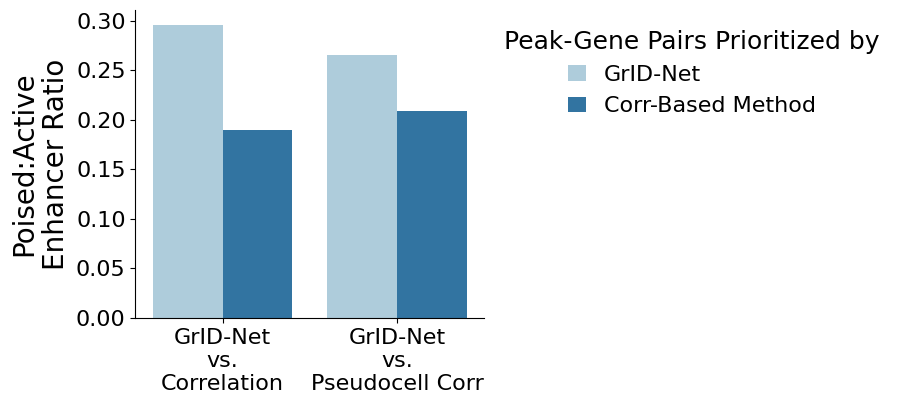

In [13]:
# eval_df['corr_diff'] = eval_df['graph.ranks.mean']-eval_df['corr.ranks.mean']
# eval_df['group_corr_diff'] = eval_df['graph.ranks.mean']-eval_df['group_corr.ranks.mean']

score_thresh = 200
results_dict = {k: [] for k in ['method','placement','ratio']}
for compare_key in ['corr_diff','group_corr_diff']: # ["{}.{}".format(m,trial_no) for m in ['corr_diff','group_corr_diff'] for trial_no in range(1,6)]:

    thresh = np.percentile(eval_df[compare_key],99)
    diff_top_atac_id = set(eval_df[(eval_df[compare_key] > thresh)]['atac_id'])
    thresh = np.percentile(eval_df[compare_key],1)
    diff_bottom_atac_id = set(eval_df[(eval_df[compare_key] < thresh)]['atac_id'])
    
    all_atac_id = set(eval_df['atac_id'])

    h3k27ac_atac_ids = set(chip_atac_id_dict[('h3k27ac',score_thresh)])
    h3k4me1_atac_ids = set(chip_atac_id_dict[('h3k4me1',score_thresh)])
    active_enhancer_atac_ids = set(chip_atac_id_dict[('active_enhancers',score_thresh)])
    
    for placement,atac_ids in zip(*[['top','bottom','all'],[diff_top_atac_id,diff_bottom_atac_id,all_atac_id]]):
        
        h3k27ac_overlaps = h3k27ac_atac_ids & atac_ids
        h3k4me1_overlaps = h3k4me1_atac_ids & atac_ids

        n_poised = h3k4me1_overlaps - h3k27ac_overlaps
        n_active = active_enhancer_atac_ids & atac_ids #h3k4me1_overlaps & h3k27ac_overlaps
    
#         print(compare_key,placement,len(n_poised)/len(n_active))
        
        results_dict['method'].append(compare_key.split(".")[0])
        results_dict['placement'].append(placement)
        results_dict['ratio'].append(len(n_poised)/len(n_active))
    
results_df = pd.DataFrame(results_dict)

all_ratio = results_df[results_df['placement'] == 'all']['ratio'].values[0]

results_df = results_df[results_df['placement'] != 'all']

# results_df['placement'] = ['{} 1% Peak-Gene Pairs'.format(n.capitalize()) if n != 'all' else n for n in results_df['placement']]
results_df['placement'] = ['GrID-Net' if n == 'top' else 'Corr-Based Method' for n in results_df['placement']]

results_df['placement'] = [n if n != 'all' else 'All Peak-Gene Pairs' for n in results_df['placement']]
results_df['method'] = ['GrID-Net\nvs.\n{}'.format(convert_name(n)) for n in results_df['method']]

plt.figure(figsize=(4.5,4))
g = sns.barplot(x='method',y='ratio',hue='placement',data=results_df,palette='Paired')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('',fontsize=16)
plt.ylabel('Poised:Active\nEnhancer Ratio',fontsize=20)
plt.legend(title='Peak-Gene Pairs Prioritized by',title_fontsize=18,fontsize=16,frameon=False,bbox_to_anchor=(1,1),handlelength=0.8)
# g.axhline(y=all_ratio,linestyle='--',color='black',linewidth=3)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'gridnet_vs_corr','poised_vs_active.png'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'gridnet_vs_corr','poised_vs_active.0125.csv'.format(dataset)), index=False)
plt.show()

In [14]:
results_df

,method,placement,ratio
0,GrID-Net\nvs.\nCorrelation,GrID-Net,0.295983
1,GrID-Net\nvs.\nCorrelation,Corr-Based Method,0.189931
3,GrID-Net\nvs.\nPseudocell Corr,GrID-Net,0.264753
4,GrID-Net\nvs.\nPseudocell Corr,Corr-Based Method,0.208602


In [15]:
results_df

,method,placement,ratio
0,GrID-Net\nvs.\nCorrelation,GrID-Net,0.295983
1,GrID-Net\nvs.\nCorrelation,Corr-Based Method,0.189931
3,GrID-Net\nvs.\nPseudocell Corr,GrID-Net,0.264753
4,GrID-Net\nvs.\nPseudocell Corr,Corr-Based Method,0.208602


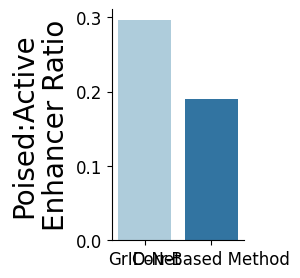

In [15]:
plt.figure(figsize=(1.7,3))
g = sns.barplot(x='placement',y='ratio',data=results_df[results_df["method"] == "GrID-Net\nvs.\nCorrelation"],palette='Paired')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.xlabel('',fontsize=16)
plt.ylabel('Poised:Active\nEnhancer Ratio',fontsize=20)
# plt.legend(title='Peak-Gene Pairs Prioritized by',title_fontsize=18,fontsize=16,frameon=False,bbox_to_anchor=(1,1),handlelength=0.8)
# g.axhline(y=all_ratio,linestyle='--',color='black',linewidth=3)

sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'gridnet_vs_corr','poised_vs_active.corr.0125.png'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'gridnet_vs_corr','poised_vs_active.corr.0125.csv'.format(dataset)), index=False)
plt.show()

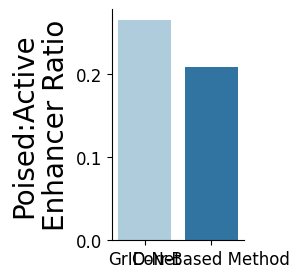

In [16]:
plt.figure(figsize=(1.7,3))
g = sns.barplot(x='placement',y='ratio',data=results_df[results_df["method"] == "GrID-Net\nvs.\nPseudocell Corr"],palette='Paired')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.xlabel('',fontsize=16)
plt.ylabel('Poised:Active\nEnhancer Ratio',fontsize=20)
# plt.legend(title='Peak-Gene Pairs Prioritized by',title_fontsize=18,fontsize=16,frameon=False,bbox_to_anchor=(1,1),handlelength=0.8)
# g.axhline(y=all_ratio,linestyle='--',color='black',linewidth=3)

sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'gridnet_vs_corr','poised_vs_active.pseudocell_corr.0125.png'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'gridnet_vs_corr','poised_vs_active.pseudocell_corr.0125.csv'.format(dataset)), index=False)
plt.show()

In [17]:
results_df

,method,placement,ratio
0,GrID-Net\nvs.\nCorrelation,GrID-Net,0.295983
1,GrID-Net\nvs.\nCorrelation,Corr-Based Method,0.189931
3,GrID-Net\nvs.\nPseudocell Corr,GrID-Net,0.264753
4,GrID-Net\nvs.\nPseudocell Corr,Corr-Based Method,0.208602


### Pseudotime @ Max Value

In [16]:
# create metacells
sc.pp.neighbors(rna_adata,n_neighbors=50,use_rep='X_schema')
group_rna_adata,group_atac_adata = create_metacells(rna_adata,atac_adata)

0
1000
2000
3000
4000


In [17]:
sc.pp.neighbors(rna_adata,use_rep='X_schema',n_neighbors=15)
sc.tl.dpt(rna_adata)

In [18]:
gene_max_dpt_dict = {g: rna_adata.obs['dpt_pseudotime'].values[idx] for g,idx in 
                zip(*[rna_adata.var.index.values,np.array(np.argmax(group_rna_adata.X,axis=0)).squeeze()])}
peak_max_dpt_dict = {str(atac_id): rna_adata.obs['dpt_pseudotime'].values[idx] for atac_id,idx in 
                zip(*[atac_adata.var.index.values,np.array(np.argmax(group_atac_adata.X,axis=0)).squeeze()])}

#### Pseudocell Correlation Ranks

In [32]:
eval_df['corr_diff'] = eval_df['graph.ranks.mean']-eval_df['corr.ranks.mean']
eval_df['group_corr_diff'] = eval_df['graph.ranks.mean']-eval_df['group_corr.ranks.mean']

compare_key = 'group_corr_diff'

thresh = np.percentile(eval_df[compare_key],99)
diff_top_dpt_diff = []
top_gene_max_dpt_list = []
top_peak_max_dpt_list = []
for g,atac_id in eval_df[(eval_df[compare_key] > thresh)][['gene','atac_id']].values:
    g = g.decode('utf-8')
    gene_max_dpt = gene_max_dpt_dict[g]
    peak_max_dpt = peak_max_dpt_dict[str(atac_id)]
    diff_top_dpt_diff.append(gene_max_dpt-peak_max_dpt)
    top_gene_max_dpt_list.append(gene_max_dpt)
    top_peak_max_dpt_list.append(peak_max_dpt)
    
diff_top_dpt_diff = np.array(diff_top_dpt_diff)

thresh = np.percentile(eval_df[compare_key],1)
diff_bottom_dpt_diff = []
bottom_gene_max_dpt_list = []
bottom_peak_max_dpt_list = []
for g,atac_id in eval_df[(eval_df[compare_key] < thresh)][['gene','atac_id']].values:
    g = g.decode('utf-8')
    gene_max_dpt = gene_max_dpt_dict[g]
    peak_max_dpt = peak_max_dpt_dict[str(atac_id)]
    diff_bottom_dpt_diff.append(gene_max_dpt-peak_max_dpt)
    bottom_gene_max_dpt_list.append(gene_max_dpt)
    bottom_peak_max_dpt_list.append(peak_max_dpt)
    
diff_bottom_dpt_diff = np.array(diff_bottom_dpt_diff)

# remove outliers
top_gene_max_dpt = np.array(top_gene_max_dpt_list)[abs(diff_top_dpt_diff) < 0.5]
top_peak_max_dpt = np.array(top_peak_max_dpt_list)[abs(diff_top_dpt_diff) < 0.5]

bottom_gene_max_dpt = np.array(bottom_gene_max_dpt_list)[abs(diff_bottom_dpt_diff) < 0.5]
bottom_peak_max_dpt = np.array(bottom_peak_max_dpt_list)[abs(diff_bottom_dpt_diff) < 0.5]

diff_top_dpt_diff = abs(diff_top_dpt_diff[abs(diff_top_dpt_diff) < 0.5])
diff_bottom_dpt_diff = abs(diff_bottom_dpt_diff[abs(diff_bottom_dpt_diff) < 0.5])


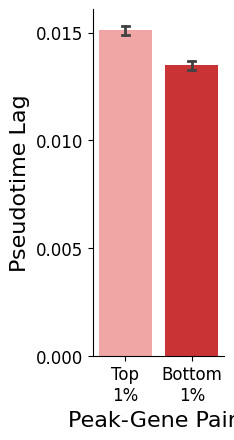

In [33]:
data_dict = {k: [] for k in ['value','placement']}
data_dict['value'].extend(diff_top_dpt_diff)
data_dict['placement'].extend(['Top\n1%']*len(diff_top_dpt_diff))

data_dict['value'].extend(diff_bottom_dpt_diff)
data_dict['placement'].extend(['Bottom\n1%']*len(diff_bottom_dpt_diff))

plot_df = pd.DataFrame(data_dict)

plt.figure(figsize=(1.7,4.5))
sns.barplot(x='placement',y='value',data=plot_df,palette=sns.color_palette('Paired')[4:],capsize=0.1,errwidth=2)

plt.xlabel('')
plt.ylabel('Pseudotime Lag',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.xlabel('Peak-Gene Pairs',fontsize=16) #  \n(GrID-Net vs. Pseudocell\nCorrelation)',fontsize=16)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'gridnet_vs_corr','pseudotime_lag.bar.0324.png'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'gridnet_vs_corr','pseudotime_lag.0125.csv'.format(dataset)), index=False)

plt.show()

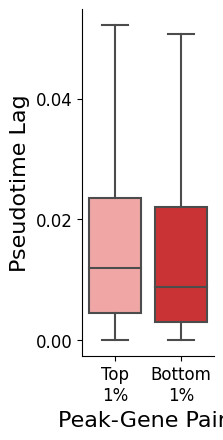

In [34]:
data_dict = {k: [] for k in ['value','placement']}
data_dict['value'].extend(diff_top_dpt_diff)
data_dict['placement'].extend(['Top\n1%']*len(diff_top_dpt_diff))

data_dict['value'].extend(diff_bottom_dpt_diff)
data_dict['placement'].extend(['Bottom\n1%']*len(diff_bottom_dpt_diff))

plot_df = pd.DataFrame(data_dict)

plt.figure(figsize=(1.7,4.5))
sns.boxplot(x='placement',y='value',data=plot_df,palette=sns.color_palette('Paired')[4:],showfliers=False) # ,capsize=0.1,errwidth=2)
# sns.stripplot(x='placement',y='value',data=plot_df)
plt.xlabel('')
plt.ylabel('Pseudotime Lag',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.xlabel('Peak-Gene Pairs',fontsize=16) #  \n(GrID-Net vs. Pseudocell\nCorrelation)',fontsize=16)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'gridnet_vs_corr','pseudotime_lag.box.0324.png'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'gridnet_vs_corr','pseudotime_lag.0125.csv'.format(dataset)), index=False)

plt.show()

In [35]:
from scipy.stats import ttest_ind

ttest_ind(plot_df[plot_df['placement'] == 'Top\n1%']['value'],
          plot_df[plot_df['placement'] == 'Bottom\n1%']['value'],equal_var=False,alternative='greater')

Ttest_indResult(statistic=10.841558040538523, pvalue=1.237276826459529e-27)

#### Pearson Correlation Ranks

In [13]:
eval_df.shape[0]*0.01

14802.18

In [36]:
eval_df['corr_diff'] = eval_df['graph.ranks.mean']-eval_df['corr.ranks.mean']
eval_df['group_corr_diff'] = eval_df['graph.ranks.mean']-eval_df['group_corr.ranks.mean']

compare_key = 'corr_diff'

thresh = np.percentile(eval_df[compare_key],99)
diff_top_dpt_diff = []
for g,atac_id in eval_df[(eval_df[compare_key] > thresh)][['gene','atac_id']].values:
    g = g.decode('utf-8')
    gene_max_dpt = gene_max_dpt_dict[g]
    peak_max_dpt = peak_max_dpt_dict[str(atac_id)]
    diff_top_dpt_diff.append(gene_max_dpt-peak_max_dpt)
diff_top_dpt_diff = np.array(diff_top_dpt_diff)

thresh = np.percentile(eval_df[compare_key],1)
diff_bottom_dpt_diff = []
for g,atac_id in eval_df[(eval_df[compare_key] < thresh)][['gene','atac_id']].values:
    g = g.decode('utf-8')
    gene_max_dpt = gene_max_dpt_dict[g]
    peak_max_dpt = peak_max_dpt_dict[str(atac_id)]
    diff_bottom_dpt_diff.append(gene_max_dpt-peak_max_dpt)
diff_bottom_dpt_diff = np.array(diff_bottom_dpt_diff)

# remove outliers
diff_top_dpt_diff = abs(diff_top_dpt_diff[abs(diff_top_dpt_diff) < 0.5])
diff_bottom_dpt_diff = abs(diff_bottom_dpt_diff[abs(diff_bottom_dpt_diff) < 0.5])

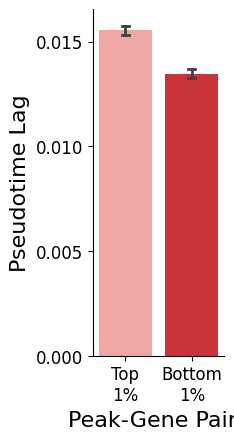

In [37]:
data_dict = {k: [] for k in ['value','placement']}
data_dict['value'].extend(diff_top_dpt_diff)
data_dict['placement'].extend(['Top\n1%']*len(diff_top_dpt_diff))

data_dict['value'].extend(diff_bottom_dpt_diff)
data_dict['placement'].extend(['Bottom\n1%']*len(diff_bottom_dpt_diff))

plot_df = pd.DataFrame(data_dict)

plt.figure(figsize=(1.7,4.5))
sns.barplot(x='placement',y='value',data=plot_df,palette=sns.color_palette('Paired')[4:],capsize=0.1,errwidth=2)

plt.xlabel('')
plt.ylabel('Pseudotime Lag',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.xlabel('Peak-Gene Pairs',fontsize=16) #  \n(GrID-Net vs. Pseudocell\nCorrelation)',fontsize=16)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
# plt.savefig(os.path.join(plot_dir,'gridnet_vs_corr','pseudotime_lag.corr.bar.0324.png'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'gridnet_vs_corr','pseudotime_lag.corr.bar.0125.csv'.format(dataset)), index=False)
plt.show()

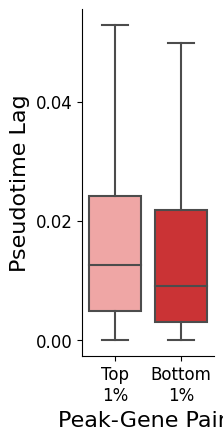

In [38]:
data_dict = {k: [] for k in ['value','placement']}
data_dict['value'].extend(diff_top_dpt_diff)
data_dict['placement'].extend(['Top\n1%']*len(diff_top_dpt_diff))

data_dict['value'].extend(diff_bottom_dpt_diff)
data_dict['placement'].extend(['Bottom\n1%']*len(diff_bottom_dpt_diff))

plot_df = pd.DataFrame(data_dict)

plt.figure(figsize=(1.7,4.5))
sns.boxplot(x='placement',y='value',data=plot_df,
               palette=sns.color_palette('Paired')[4:],showfliers=False,) # ,capsize=0.1,errwidth=2)
plt.xlabel('')
plt.ylabel('Pseudotime Lag',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.xlabel('Peak-Gene Pairs',fontsize=16) #  \n(GrID-Net vs. Pseudocell\nCorrelation)',fontsize=16)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'gridnet_vs_corr','pseudotime_lag.corr.box.0324.png'.format(dataset)), dpi=500, bbox_inches = "tight")
# results_df.to_csv(os.path.join(plot_dir,'gridnet_vs_corr','pseudotime_lag.corr.bar.0125.csv'.format(dataset)), index=False)
plt.show()

In [39]:
from scipy.stats import ttest_ind

ttest_ind(plot_df[plot_df['placement'] == 'Top\n1%']['value'],
          plot_df[plot_df['placement'] == 'Bottom\n1%']['value'],equal_var=False,alternative='greater')

Ttest_indResult(statistic=13.728019613483548, pvalue=4.7246211908045935e-43)

#### Visualization of Example Lagged Peak-Gene Pairs

In [59]:
sorted_eval_df = eval_df.sort_values("graph.ranks.mean",ascending=False)
sorted_eval_df["ranking"] = np.arange(sorted_eval_df.shape[0])

In [60]:
selected_peak_gene_pairs = [(250132,b'CBWD5'),(258462,b'TRAF1')] #
#                             (443939,b'FAM242A'),(56835,b'PLGLB2'),
#                             (185682,b'NKAIN2'),(185671,b'NKAIN2'),(393120,b'CDYL2'),
#                             (222614,b'FAM66A'),(336553,b'MIPEP'),(275107,b'AIFM2'),
#                             (412973,b'CCDC40'),(412951,b'CCDC40'),(402120,b'LIG3'),
#                             (434138,b'SLC7A9'),(17755, b'MSH4'),(258453, b'TRAF1'),
#                             (258455, b'TRAF1'),(258462, b'TRAF1'),(248240, b'IFT74'),
#                             (248241, b'IFT74'),(248256, b'IFT74'),(304424, b'MRE11'),
#                             (304428, b'MRE11')]

250132 b'CBWD5'


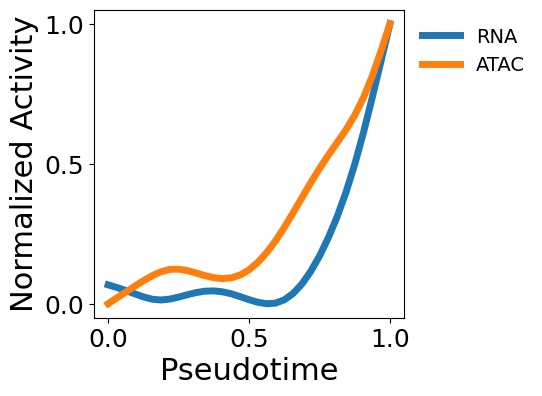

258462 b'TRAF1'


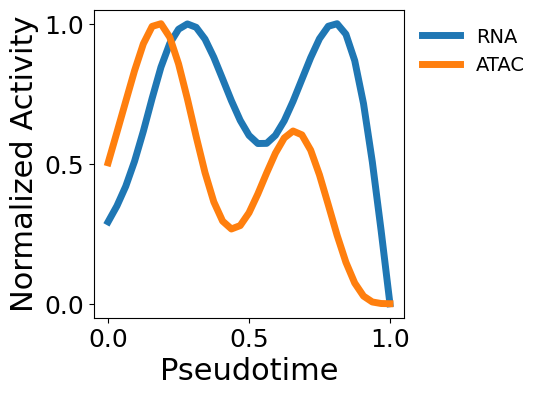

In [66]:
from scipy.interpolate import make_smoothing_spline
from scipy.stats import spearmanr

bin_size = 150
lam = 100
    

for selected_peak,selected_gene in selected_peak_gene_pairs:
#     selected_peak,selected_gene = sorted_peak_gene_pairs[idx]
    print(selected_peak,selected_gene)

    sorted_idx = np.argsort(group_rna_adata.obs["dpt_pseudotime"])

    sorted_rna_values = np.array(group_rna_adata[:,selected_gene.decode()].X.toarray()).squeeze()[sorted_idx]
    sorted_atac_values = np.array(group_atac_adata[:,selected_peak].X.toarray()).squeeze()[sorted_idx]

    sorted_rna_values = [sorted_rna_values[i:i+bin_size].mean()
                         for i in range(0,len(sorted_rna_values)-bin_size,bin_size)]
    sorted_atac_values = [sorted_atac_values[i:i+bin_size].mean() 
                          for i in range(0,len(sorted_atac_values)-bin_size,bin_size)]
    dpt_values = np.arange(0,len(sorted_rna_values))

#         if spearmanr(dpt_values,sorted_rna_values)[0] > 0.3 and spearmanr(dpt_values,sorted_atac_values)[0] > 0.3:

    rna_func = make_smoothing_spline(dpt_values,sorted_rna_values,lam=lam)
    atac_func = make_smoothing_spline(dpt_values,sorted_atac_values,lam=lam)

    sorted_rna_values = rna_func(dpt_values)
    sorted_atac_values = atac_func(dpt_values)

    # min-max normalize
    sorted_rna_values = (sorted_rna_values-sorted_rna_values.min())/(sorted_rna_values.max()-sorted_rna_values.min())
    sorted_atac_values = (sorted_atac_values-sorted_atac_values.min())/(sorted_atac_values.max()-sorted_atac_values.min())

    plt.figure(figsize=(4,4))
    plt.plot(dpt_values/max(dpt_values),sorted_rna_values/sorted_rna_values.max(),
             linewidth=5,label="RNA")
    plt.plot(dpt_values/max(dpt_values),sorted_atac_values/sorted_atac_values.max(),
             linewidth=5,label="ATAC")
    plt.legend(fontsize=14,bbox_to_anchor=(1,1),frameon=False)
    plt.xlabel("Pseudotime",fontsize=22)
    plt.ylabel("Normalized Activity",fontsize=22)
    plt.xticks([0,0.5,1],fontsize=18)
    plt.yticks([0,0.5,1],fontsize=18)

    plot_dir = '/data/cb/alexwu/mm_finemap/figures'
    plt.savefig(os.path.join(plot_dir,'gridnet_vs_corr','lag_activity_plots.{}_{}.png'.format(selected_peak,selected_gene)), dpi=500, bbox_inches = "tight")

    plt.show()

In [34]:
eval_df[(eval_df["gene"] == b'TRAF1') & (eval_df["atac_id"] == 258462)]

,chr_no,hic,dist,atac_id,gene,corr,group_corr,gene_percent_cells,peak_percent_cells,eqtl.all,...,corr_diff.1,group_corr_diff.1,corr_diff.2,group_corr_diff.2,corr_diff.3,group_corr_diff.3,corr_diff.4,group_corr_diff.4,corr_diff.5,group_corr_diff.5
"(258462, b'TRAF1')",b'chr9',NaN,13561.0,258462,b'TRAF1',0.002664,-0.02668,0.011905,0.005208,5.189230e-11,...,0.997381,1.026726,1.006509,0.96724,0.997604,0.907393,1.00635,0.941703,0.99794,0.992711


## Gene Set Enrichment

In [12]:
eval_df['corr_diff'] = eval_df['graph.ranks.mean']-eval_df['corr.ranks.mean']
eval_df['group_corr_diff'] = eval_df['graph.ranks.mean']-eval_df['group_corr.ranks.mean']
eval_df['corr_sum'] = eval_df['graph.ranks.mean'].values+eval_df['corr.ranks.mean'].values
eval_df['group_corr_sum'] = eval_df['graph.ranks.mean'].values+eval_df['group_corr.ranks.mean'].values

### GSEA Pre-rank

In [15]:
import gseapy as gp

genesets2use = ['GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021','Reactome_2016','CellMarker_Augmented_2021',
                'Jensen_TISSUES','KEGG_2021_Human']

for score_key in ['corr_sum','group_corr_sum']: #['corr_diff','group_corr_diff']:
    sorted_genes = eval_df.sort_values(score_key,ascending=False)['gene'].drop_duplicates().values

    save_dir = '/data/cb/alexwu/mm_finemap/results/enrichment'

    rnk = pd.DataFrame(sorted_genes)
    rnk[1] = rnk.shape[0]-np.arange(rnk.shape[0])

    for gene_set in genesets2use:
        print(score_key,gene_set)
        pre_res = gp.prerank(rnk=rnk, gene_sets=gene_set,processes=8,
                             outdir=os.path.join(save_dir,'gsea_prerank_{}_{}'.format(gene_set,score_key)), seed=1)


group_corr_sum GO_Biological_Process_2021


In [16]:
save_dir = '/data/cb/alexwu/mm_finemap/results/enrichment'

genesets2use = ['GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021','Reactome_2016','CellMarker_Augmented_2021',
                'Jensen_TISSUES','KEGG_2021_Human']
    
results_df_list = []

for score_key in ['corr_diff','group_corr_diff']:
    for gene_set in genesets2use:

        file_path = os.path.join(save_dir,'gsea_prerank_{}_{}'.format(gene_set,score_key),'gseapy.prerank.gene_sets.report.csv')
        if os.path.exists(file_path):
            results_df = pd.read_csv(file_path)
            results_df['gene_set'] = gene_set
            results_df['score_key'] = score_key
            results_df_list.append(results_df)

results_df = pd.concat(results_df_list)
results_df = results_df[results_df['fdr'] < 0.01]

In [27]:
from collections import Counter

for n,c in Counter(results_df[results_df['es'] < 0]['Term']).most_common():
    if c == 2:
        print(n)

Golgi to plasma membrane transport (GO:0006893)
SRP-dependent cotranslational protein targeting to membrane (GO:0006614)
cotranslational protein targeting to membrane (GO:0006613)
cytoplasmic translation (GO:0002181)
negative regulation of cell cycle G2/M phase transition (GO:1902750)
nuclear-transcribed mRNA catabolic process (GO:0000956)
nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)
positive regulation of TOR signaling (GO:0032008)
regulation of alternative mRNA splicing, via spliceosome (GO:0000381)
regulation of cellular amine metabolic process (GO:0033238)
regulation of cellular amino acid metabolic process (GO:0006521)
regulation of mRNA processing (GO:0050684)
regulation of mRNA splicing, via spliceosome (GO:0048024)
regulation of neurogenesis (GO:0050767)
spliceosomal complex assembly (GO:0000245)
mitochondrial proton-transporting ATP synthase complex (GO:0005753)
polysomal ribosome (GO:0042788)
proton-transporting ATP synthase complex (GO:004

In [29]:
0.0000001

1e-07

In [28]:
inds2keep = [i for i,n in enumerate(results_df['Term']) if 'brain' in n.lower() or 'neur' in n.lower()]
results_df.iloc[inds2keep]

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,gene_set,score_key
20,regulation of neurogenesis (GO:0050767),-0.143851,inf,NaN,0.000000,62,41,HES7;BHLHE40;ARNTL;GPER1;NUMBL;WNT7A;HEY1;MME;...,ARNTL;GPER1;NUMBL;WNT7A;HEY1;MME;LIG4;PRUNE1;O...,GO_Biological_Process_2021,corr_diff
9,Lake Et al.Science.Ex7:Brain,-0.137315,inf,NaN,0.000000,100,86,PCDH18;TRIL;ANK2;CXCL12;BRINP1;PTPN5;TMEM200C;...,ADCYAP1R1;OLFM1;MAP1B;NFASC;ZNF536;DCLK1;TUB;T...,CellMarker_Augmented_2021,corr_diff
10,Lake Et al.Science.In1:Brain,-0.144204,inf,NaN,0.000000,98,86,ST8SIA3;SOX1;CNTN2;PTPN5;KCNA2;XKR7;ZDHHC22;LR...,MGAT3;CTNND2;ADGRA1;LRRC55;NEFL;FXYD6;KCNC1;RA...,CellMarker_Augmented_2021,corr_diff
12,Neuron:Spinal Cord,-0.226637,inf,NaN,0.000000,100,96,PCDHB4;PCDHB10;STK32A;EFNB3;ANK2;PCDHB14;BRINP...,RBFOX2;ATP9A;MAP1B;NFASC;DCLK1;PCLO;PLPPR5;PSD...,CellMarker_Augmented_2021,corr_diff
13,Neuronal Progenitor cell:Undefined,-0.149423,inf,NaN,0.000000,101,97,SCRT1;ST8SIA3;SOX1;CNTN2;EFNB3;SLITRK1;AQP4;TM...,CTNND2;ADGRA1;MAP2;BSN;KCNC1;SOX21;TUBB2B;CELF...,CellMarker_Augmented_2021,corr_diff
21,Neural Crest cell:Undefined,0.668655,1.878828,0.000000,0.000566,22,15,CSPG4;ITGA4;SNAI2;NEUROG1;SOX10;NEUROG2;NOTCH1...,CSPG4;ITGA4;SNAI2;NEUROG1;SOX10;NEUROG2,CellMarker_Augmented_2021,corr_diff
72,Cancer Stem cell:Brain,0.550207,1.671194,0.002010,0.005697,30,24,FUT4;SCAMP3;CLCC1;CD44;BMI1;CADM1;MSI1;THY1;NF...,FUT4;SCAMP3;CLCC1;CD44;BMI1,CellMarker_Augmented_2021,corr_diff
73,Cancer Stem-Like cell:Brain,0.590709,1.667565,0.005139,0.005837,100,15,TEK;FUT4;IRAK3;CALCRL;NOTCH4;MMRN2;PCDH12;DAB2...,TEK;FUT4;IRAK3;CALCRL;NOTCH4;MMRN2;PCDH12;DAB2...,CellMarker_Augmented_2021,corr_diff
0,Brain cortex cell line,-0.153136,inf,NaN,0.000000,211,189,CRYM;ACAT1;IRGQ;ITPA;PSMC2;HBG1;ECHS1;OXCT1;PR...,ARHGDIA;RUVBL1;UQCRC1;RHOB;PCBP1;FSCN1;ENO2;CA...,Jensen_TISSUES,corr_diff
18,regulation of neurogenesis (GO:0050767),-0.215083,inf,NaN,0.000000,62,41,NUMBL;OPRM1;BHLHE40;GPER1;MME;WNT7A;HES7;PRUNE...,NUMBL;OPRM1;BHLHE40;GPER1;MME;WNT7A;HES7;PRUNE...,GO_Biological_Process_2021,group_corr_diff


In [17]:
save_dir = '/data/cb/alexwu/mm_finemap/results/enrichment'

genesets2use = ['GO_Biological_Process_2021','GO_Molecular_Function_2021',
                'GO_Cellular_Component_2021','Reactome_2016','CellMarker_Augmented_2021',
                'Jensen_TISSUES','KEGG_2021_Human']
    
results_df_list = []

for score_key in ['corr_sum','group_corr_sum']:
    for gene_set in genesets2use:

        file_path = os.path.join(save_dir,'gsea_prerank_{}_{}'.format(gene_set,score_key),'gseapy.prerank.gene_sets.report.csv')
        if os.path.exists(file_path):
            results_df = pd.read_csv(file_path)
            results_df['gene_set'] = gene_set
            results_df['score_key'] = score_key
            results_df_list.append(results_df)

results_df = pd.concat(results_df_list)
results_df = results_df[results_df['fdr'] < 0.01]

In [19]:
results_df

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,gene_set,score_key
0,cellular response to chemokine (GO:1990869),0.733648,2.115239,0.000000,0.000000,60,17,CCL3L1;CCL4;CCL3;DOCK8;CXCL13;SH2B3;CXCL12;PTK...,CCL3L1;CCL4;CCL3;DOCK8;CXCL13;SH2B3;CXCL12;PTK...,GO_Biological_Process_2021,corr_sum
1,Fc receptor mediated stimulatory signaling pat...,-0.154064,inf,NaN,0.000000,74,58,ARPC4;NR4A3;PLA2G6;CD247;PLPP4;VAV3;WIPF1;MYO1...,VAV3;WIPF1;MYO1C;MAPK3;PLD2;ARPC1B;LIMK1;ABI1;...,GO_Biological_Process_2021,corr_sum
2,Fc-gamma receptor signaling pathway involved i...,-0.194255,inf,NaN,0.000000,71,57,ARPC4;PLA2G6;CD247;PLPP4;VAV3;WIPF1;MYO1C;MAPK...,PLPP4;VAV3;WIPF1;MYO1C;MAPK3;PLD2;ARPC1B;LIMK1...,GO_Biological_Process_2021,corr_sum
3,Golgi to plasma membrane transport (GO:0006893),-0.196981,inf,NaN,0.000000,48,43,GCC2;GOLGA7;BBS1;NSF;BLZF1;EXOC8;GOPC;RAB26;GG...,EXOC8;GOPC;RAB26;GGA3;RAB34;VAMP4;LLGL1;ARFRP1...,GO_Biological_Process_2021,corr_sum
4,SRP-dependent cotranslational protein targetin...,-0.280948,inf,NaN,0.000000,90,85,SRP54;SRP19;ZFAND2B;SRP68;SEC61A1;RPS13;RPLP1;...,SRP19;ZFAND2B;SRP68;SEC61A1;RPS13;RPLP1;SRP72;...,GO_Biological_Process_2021,corr_sum
5,cotranslational protein targeting to membrane ...,-0.219728,inf,NaN,0.000000,94,89,SRP54;SSR1;SRPRA;SRP19;SRP68;SEC61A1;RPS13;RPL...,SEC61A1;RPS13;RPLP1;SRP72;SEC63;SRP9;RPL12;SIL...,GO_Biological_Process_2021,corr_sum
6,cytoplasmic translation (GO:0002181),-0.210879,inf,NaN,0.000000,93,87,RWDD1;RPL22L1;RPL26L1;DRG1;DRG2;RPS13;RPLP1;ZC...,RPS13;RPLP1;ZC3H15;EIF3M;EIF3I;GSPT1;RPL12;ETF...,GO_Biological_Process_2021,corr_sum
7,"mitochondrial electron transport, NADH to ubiq...",-0.185021,inf,NaN,0.000000,39,37,NDUFA2;NDUFB5;NDUFB3;NDUFA4;NDUFA5;NDUFB6;NDUF...,NDUFA3;NDUFA8;NDUFS4;NDUFAF1;NDUFV3;NDUFA10;ND...,GO_Biological_Process_2021,corr_sum
8,nuclear-transcribed mRNA catabolic process (GO...,-0.173899,inf,NaN,0.000000,171,160,CNOT9;ERI1;MRTO4;SMG9;CNOT8;DCP1B;CNOT3;EXOSC9...,DCP1B;CNOT3;EXOSC9;LSM1;EXOSC8;DCPS;EXOSC4;DHX...,GO_Biological_Process_2021,corr_sum
9,"nuclear-transcribed mRNA catabolic process, no...",-0.296120,inf,NaN,0.000000,113,106,SMG9;DHX34;UPF1;PYM1;HELZ2;UPF2;SMG8;NCBP2;MAG...,DHX34;UPF1;PYM1;HELZ2;UPF2;SMG8;NCBP2;MAGOHB;P...,GO_Biological_Process_2021,corr_sum


In [18]:
inds2keep = [i for i,n in enumerate(results_df['Term']) if 'brain' in n.lower() or 'neur' in n.lower()]
results_df.iloc[inds2keep]

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,gene_set,score_key


### Enrichr

In [57]:
import gseapy as gp

background_genes = list(set(eval_df['gene']))
outdir = '/data/cb/alexwu/mm_finemap/results/enrichment/gridnet_vs_corr'

for compare_key in ['corr_diff','group_corr_diff']:
    
    print(compare_key)
    
    thresh = np.percentile(eval_df[compare_key],99)
    diff_top_genes = list(set(eval_df[(eval_df[compare_key] > thresh)]['gene']))

    enr = gp.enrichr(gene_list=diff_top_genes,
                     gene_sets=genesets2use,
                     organism='Human',
                     description='test_name',
                     outdir=os.path.join(outdir,compare_key),
                     background=background_genes,
                     cutoff=0.05
                    )
    results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]
    results_df.to_csv(os.path.join(outdir,'top.{}.enrichr.tsv'.format(compare_key)),
                      sep='\t',index=False)
                      
    thresh = np.percentile(eval_df[compare_key],1)
    diff_bottom_genes = list(set(eval_df[(eval_df[compare_key] < thresh)]['gene']))
    
    enr = gp.enrichr(gene_list=diff_bottom_genes,
                     gene_sets=genesets2use,
                     organism='Human',
                     description='test_name',
                     outdir=os.path.join(outdir,score_key),
                     background=background_genes,
                     cutoff=0.05
                    )
    results_df = enr.results[enr.results['Adjusted P-value'] < 0.1]
    results_df.to_csv(os.path.join(outdir,'bottom.{}.enrichr.tsv'.format(compare_key)),
                      sep='\t',index=False)

corr_diff


2022-05-30 21:50:56,711 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05
2022-05-30 21:51:08,583 Warning: No enrich terms using library GO_Cellular_Component_2021 when cutoff = 0.05
2022-05-30 21:51:21,119 Warning: No enrich terms using library CellMarker_Augmented_2021 when cutoff = 0.05
2022-05-30 21:51:27,233 Warning: No enrich terms using library Jensen_TISSUES when cutoff = 0.05


group_corr_diff


2022-05-30 21:52:17,830 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05
2022-05-30 21:52:23,654 Warning: No enrich terms using library GO_Molecular_Function_2021 when cutoff = 0.05
2022-05-30 21:52:47,162 Warning: No enrich terms using library Jensen_TISSUES when cutoff = 0.05
